# Data Anaysis Project part1:

I am using Vancouver rental ads on craigslist to analyze rental market. Later, I will create the class to be able to analyze dynamically. Also, I will start collecting the data and save them to the CSV, so I can analyze the trend of the rental market as well. 

I will follow what I am learning from Google Data Analytics course to complete this project.

* Ask
* Prepare
* Process
* Analyze
* Share
* Act



## Overview of the project:

Analyze housing rental market in Fraser Valley to find out what is hot to real estate investors in this area. Iam going to create the code to analyze dynamically so the investors can apply in their area for their own use.  


## ASK 
    
    Find out what is 'HOT' in the market for investor, so I can find a property for them. Find out supply and demand of the rental housing market and calculate appropreate purchase price. 

#### What are the questions to ask?
Supply side:
* How much is the market rental price?
* What type of the rental is most popular and least popular?
* How many ads per day? Number of supply 
* Is rental price rising or decreasing over time?
* What is the correlation between housing price and rental price?
* From those questions, what is my prediction of the rental market? 

Demand side:
* What kind of propety does people look for rent?
* What is the price range they are looking for?
* What are the purposes of renting. (Who is looking for rent)


#### Review Google Data Analysis course and create checklist:
* Ask effective questions
* Define the problems
* Using structured thinking
* Communicate with others



## Prepare  

#### Using Craigslist add to collect market data: (Supply side)
Scrape craigslist rental housing pages and store in csv file. 

<a href='https://github.com/rileypredum/East-Bay-Housing-Web-Scrape/blob/master/EB_Apt_Prices_Final.ipynb'>Code: I will use this code and modify for my situation.  </a> <br>
<a href='https://towardsdatascience.com/web-scraping-craigslist-a-complete-tutorial-c41cea4f4981'>Explaning</a>


#### Review from Google Data Analysis course:
* Understand how data is generated and collect. 
    * The data is collected from Craigslist ads. 
* Identify and use different data formats, types, and structures. 
* Make sure data is unbiased and credible. 
    * The data is live advertisement, so it is great to see today's market price. However, craigslist doesn't seems today's most favorite site to advertize so it might not accurately show the reality. 
* Organize and protect data. 

In [1]:
# Import libralis
from requests import get
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import numpy as np

from time import sleep
import re
from random import randint
from warnings import warn
from time import time
from IPython.display import clear_output

In [2]:
class Url:
    def __init__(self, city_name, sub_city=None, num_post=0):
        self.city_name = city_name
        self.sub_city = sub_city
        self.num_post = num_post
        self.url = self.get_url()
        
    def get_url(self):
        if self.city_name == 'Abbotsford':
            url = f'https://{self.city_name.lower()}.craigslist.org/search/apa?s={self.num_post}sort=date&bundleDuplicates=1&min_price=&max_price=&availabilityMode=0&sale_date=all+dates'
        else:
            url = f'https://{self.city_name.lower()}.craigslist.org/search/{self.sub_city}/apa?s={self.num_post}sort=date&bundleDuplicates=1&min_price=&max_price=&availabilityMode=0&sale_date=all+dates'
        return url 

In [3]:
# Vanvouver rental housing
url = Url("Vancouver", 'van')
url_ = url.url

response = get(url_)


soup = BeautifulSoup(response.text, 'html.parser')

posts = soup.find_all('li', class_='result-row')
print(type(posts)) # to double check that I got resultSet
print(len(posts)) # to double check I got 120 elements

<class 'bs4.element.ResultSet'>
126


In [4]:
%%time
# Find the total number of posts to find the limit of the pagination
city = 'Vancouver'
sub_city = 'van'
response = get(url_)
soup = BeautifulSoup(response.text, 'html.parser')
posts = soup.find_all('li', class_='result-row')
results_num = soup.find('div', class_='search-legend')
results_total = int(results_num.find('span', class_='totalcount').text)
print(f"Total number of search result: {results_total}")

# each page has 119 posts so each new page is defined as follows; s=120, s=240, .....
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_date = []
post_cities = []
num_bedroom = []
sqfts = []
prices = []
post_titles = []
post_links = []

for page in pages:
    
    # get request
    url = Url(city_name=city, sub_city=sub_city, num_post=page)
    url_ = url.url
    response = get(url_)
    
    sleep(1)
    
    # throw warning for status code that are not 200
    if response.status_code != 200:
        warn(f'Request: {requests}; Status code: {response.status_code}')
        
    soup = BeautifulSoup(response.text, 'html.parser')
    
    posts = soup.find_all('li', class_='result-row')
    
    
    # Extract data 
    for post in posts:
        
        if post.find('span', class_ = 'result-hood') is not None:
            
            # Posting date
            post_datetime = post.find('time', class_='result-date')['datetime']
            post_date.append(post_datetime)
            
            # Neighbourhoods
            post_city = post.find('span', class_='result-hood').text.strip('( )')
            post_cities.append(post_city)
            
            # title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_titles.append(post_title_text)
            
            # Post price in integer
            price = int(post.find('span', class_='result-price').text.split('$')[1].replace(',', ''))
            prices.append(price)
            
            # Post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    num_bedroom.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    num_bedroom.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    num_bedroom.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    num_bedroom.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                num_bedroom.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    num_bedroom.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
        iterations += 1
        #print("Page" + str(iterations) + "Scraped Successfully!")   

Total number of search result: 3000
CPU times: total: 3.98 s
Wall time: 39.5 s


In [5]:
# create DataFrame
df = pd.DataFrame({'Post Datetime': post_date,
                   'City Code': city.upper()[:3],
                   'Area Code': sub_city.upper(),
                   'Post Title': post_titles,
                   'Post URL': post_links,
                  'Neighborhood': post_cities,
                  'Bedroom': num_bedroom,
                  'SQFT': sqfts,
                  'Price': prices})

print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3056 entries, 0 to 3055
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Post Datetime  3056 non-null   object 
 1   City Code      3056 non-null   object 
 2   Area Code      3056 non-null   object 
 3   Post Title     3056 non-null   object 
 4   Post URL       3056 non-null   object 
 5   Neighborhood   3056 non-null   object 
 6   Bedroom        2818 non-null   object 
 7   SQFT           2712 non-null   float64
 8   Price          3056 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 215.0+ KB
None


,Post Datetime,City Code,Area Code,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price
0,2022-12-22 21:01,VAN,VAN,2 bedroom 1 bathroom basement for rent unfurni...,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,2,900.0,2100
1,2022-12-22 21:01,VAN,VAN,NEW BUILDING - Pet Friendly Studio@1170 Barcla...,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,NaN,400.0,2775
2,2022-12-22 21:00,VAN,VAN,NEW BUILDING - Pet Friendly Studio@1170 Barcla...,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,NaN,400.0,2775
3,2022-12-22 20:57,VAN,VAN,Bright and spacious 2 Bedroom Ground Floor Eas...,https://vancouver.craigslist.org/van/apa/d/van...,East Vancouver Killarney,2,750.0,1950
4,2022-12-22 20:52,VAN,VAN,FULLY FURNISHED Luxury 1 BR and Flex Room TELU...,https://vancouver.craigslist.org/van/apa/d/van...,777 Richards St and Robson St,1,610.0,2888


In [9]:
# Get all the Nighborhood start with number, I assume those are address. Then identify the area using google geocoding API.
address = []
for string in df["Neighborhood"].unique():
    if string[0].isdigit():
        address.append(string)
address

['777 Richards St and Robson St',
 '1022 Nelson Street, Vancouver, BC',
 '1283 Howe Street',
 '389 West 59th',
 '1238 Melville Street, Vancouver',
 '1803-1483 Homer St, Vancouver, BC',
 '166 E. 20th Ave, Vancouver, BC',
 '6 - 3551 Kingsway, Vancouver, BC',
 '1281 WEST CORDOVA ST. VANCOUVER, B.C.',
 '455 Abbott Street, Vancouver, BC.',
 '1009 HARWOOD ST',
 '2338 Orchard Ln',
 '1068 hornby st',
 '1199 Seymour Street Vancouver',
 '1644 NELSON ST.',
 '777 Richards Street Vancouver, B.C.',
 '1708 Ontario Street, Vancouver BC',
 '1026 West 13th Avenue, Vancouver',
 '282 West 44th Avenue, Vancouver',
 '2615 Columbia Street, Vancouver, BC',
 '747 E 3rd St North Vancouver, BC V7L 1G8',
 '19xx Quilchena Crescent',
 '26xx W. King Edward Ave.',
 '7638 Cambie Street',
 '905 E 41st AVE, Vancouver V5W 1P8',
 '1111 Alberni Street, Vancouver V6E 4V2',
 '938 Smithe Street Downtown Vancouver',
 '1239 West Georgia',
 '1200 Alberni Street',
 '1372 Seymour',
 '588 Broughton Street',
 '938 Smithe Street',
 '

If Neighborhood starts with number, then check the area name with google geocoding API. 

if Neighborhood is ara name, then use as area name.

clean up all the Neighborhood - cut , / and show same thing but differently. Also, make all lower case. 


## Process


* Create and transform data. 
* Maintan data integrity
    * Validility 
    * Accuracy
    * Completeness
    * Consistency
* Test data
### Clean Data
    * Remove duplicate    
    * Find null values then decide how to fill or drop entire row
    * Sorting
    * Filtering
Verify and report on cleaning results

Check the dataset I created from the Craigslist ad and final adjustment of the dataset to analyze the data. 

First to check the dataset:

#### Use visualization to understand the data. 

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3057 entries, 0 to 3056
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Post Datetime  3057 non-null   object 
 1   City Code      3057 non-null   object 
 2   Area Code      3057 non-null   object 
 3   Post Title     3057 non-null   object 
 4   Post URL       3057 non-null   object 
 5   Neighborhood   3057 non-null   object 
 6   Bedroom        2817 non-null   object 
 7   SQFT           2714 non-null   float64
 8   Price          3057 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 215.1+ KB


Convert Post Datetime object to Datetime.

Connect City Code and Area Code then create Post Area Code. (In this DataFrame, it only contain one area of data but I am storeing 13 different area in CSV file. This code will distinguish the data in different regions.)

I would like to distingish FULLY FURNISHED suite and not furnished suite. I will create another column to show if it isTURE or FALSE. I noticed the title says if it is furnished suite or not (If not on the title, I assume that the suite is not furnished) 

Also, I noticed that the number of bedroom is string, so I will convert to integer. 

Sort DataFrame Descending order by Post Datetime.

Remove duplicate. 

Make Neighborhood all lowercase. 

Is there any oulier? 

In [71]:
# Convert Datetime then split seperate columns
df['Post Datetime'] = pd.to_datetime(df["Post Datetime"])
df['Post Date'] = df['Post Datetime'].dt.date
df['Post Time'] = df['Post Datetime'].dt.time

df["PostAreaCode"] = df["City Code"] + df["Area Code"]

lower_neighbor = []
for area in df["Neighborhood"]:
    neighbor = area.lower()
    lower_neighbor.append(neighbor)
df["Neighborhood"] = lower_neighbor

df = df[["PostAreaCode", 'Post Datetime', 'Post Date', 'Post Time', 'Post Title', 'Post URL', 'Neighborhood', 'Bedroom', 'SQFT', 'Price']]
df.head()

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price
0,VANVAN,2022-12-21 20:52:00,2022-12-21,20:52:00,31ST FLOOR-Pet Welcome-Available April 1-Furni...,https://vancouver.craigslist.org/van/apa/d/van...,yaletown,NaN,465.0,2750
1,VANVAN,2022-12-21 20:51:00,2022-12-21,20:51:00,31ST FLOOR-Pet Welcome-Available April 1-Furni...,https://vancouver.craigslist.org/van/apa/d/van...,yaletown,NaN,465.0,2750
2,VANVAN,2022-12-21 20:51:00,2022-12-21,20:51:00,31 FLOOR-Pet Allowed Furnished Studio@1289 Hor...,https://vancouver.craigslist.org/van/apa/d/van...,yaletown,NaN,465.0,2750
3,VANVAN,2022-12-21 20:50:00,2022-12-21,20:50:00,31ST FLOOR-Pet Welcome Furnished Studio@1289 H...,https://vancouver.craigslist.org/van/apa/d/van...,yaletown,NaN,465.0,2750
4,VANVAN,2022-12-21 20:48:00,2022-12-21,20:48:00,A/C Furnished Short Term Apartment Unit SMART ...,https://vancouver.craigslist.org/van/apa/d/van...,yaletown,1,500.0,3000


In [72]:
# Convert Bedroom number strings to Integer then NaN value to 0 assume 0 bedroom is studio appartment. 
df["Bedroom"] = pd.to_numeric(df["Bedroom"], errors='ignore').astype('Int64')
df["Bedroom"] = df["Bedroom"].fillna(0)

In [73]:
%%time
# Check if word 'furnished' in the title post. 
search_word = 'furnished'
furnished = []
for i in range(len(df)):
    post_title_list = df['Post Title'][i].lower().split(" ")
    if any(word == search_word for word in post_title_list):
        furnished.append(True)
    else:
        furnished.append(False)
df["IsFurnished"] = furnished

CPU times: total: 0 ns
Wall time: 14.4 ms


In [74]:
df.sort_values(by="Price", ascending=False).head()

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished
2080,VANVAN,2022-12-12 10:56:00,2022-12-12,10:56:00,Ultra Customized Morden Luxury House In West P...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,4,3958.0,25000,False
698,VANVAN,2022-12-20 11:11:00,2022-12-20,11:11:00,Furnished Two Bedroom Sub-Penthouse at Shangri...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,2694.0,25000,True
695,VANVAN,2022-12-20 11:11:00,2022-12-20,11:11:00,Furnished Two Bedroom Sub-Penthouse at Shangri...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,2694.0,25000,True
746,VANVAN,2022-12-20 09:41:00,2022-12-20,09:41:00,Luxury Furnished 3 Bed + Den 4 Bath Condo at T...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,3,2223.0,24995,True
1031,VANVAN,2022-12-19 12:19:00,2022-12-19,12:19:00,Furnished luxury Mansion 7 bed/7 bath availabl...,https://vancouver.craigslist.org/van/apa/d/wes...,west vancouver,6,10000.0,22880,True


#### Clean up the neighborhood. 

In [75]:
# After split neighborhood to list, back to one string
def back_to_string(word_list):
    neighbour = ''
    
    for word in word_list:
        neighbour += (word + ' ')
    return neighbour

neighourhood = []
for i in range(len(df)):
    neighbor_word_list = df["Neighborhood"][i].replace(',', ' ').replace('/', ' ').split(" ")
    if 'yaletown' in neighbor_word_list:
        neighbor = 'yaletown'
    elif 'downtown' in neighbor_word_list:
        neighbor = 'downtown'
    elif 'dt' in neighbor_word_list:
        neighbor = 'downtown'
    #elif "west" and 'vancouver' in neighbor_word_list:
     #   neighbor = 'west vancouver'
    elif 'city' and 'vancouver' in neighbor_word_list:
        neighbor = 'vancouver'
    elif 'west' and 'end' in neighbor_word_list:
        neighbor = 'west end'
    elif len(neighbor_word_list) > 4:
        neighbor = 'vancouver'
    else:
        neighbor = back_to_string(neighbor_word_list)
    neighourhood.append(neighbor)
df['Neighborhood'] = neighourhood

In [76]:
# Sort DataFrame by Datetime
df.sort_values(by="Post Datetime", axis=0, ascending=False, inplace=True)

In [77]:
# Remove duplicates by post title
df.drop_duplicates(subset="Post Title", inplace=True)
len(df)

2624

In [80]:
df[50:55]

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished
55,VANVAN,2022-12-21 18:56:00,2022-12-21,18:56:00,(ORCA_REF#3796M)***Fully Furnished and luxurio...,https://vancouver.craigslist.org/van/apa/d/bur...,burnaby heights,5,2500.0,6500,True
56,VANVAN,2022-12-21 18:52:00,2022-12-21,18:52:00,1 bed/1bath apartment for rent at Vancouver we...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,645.0,2200,False
57,VANVAN,2022-12-21 18:39:00,2022-12-21,18:39:00,(ORCA_REF#1101-1000)2 bdrm 2 bath apt,https://vancouver.craigslist.org/van/apa/d/van...,downtown,2,1350.0,5000,False
60,VANVAN,2022-12-21 18:31:00,2022-12-21,18:31:00,2 Bed 2 Bath Luxury Condo with a Wrap Around B...,https://vancouver.craigslist.org/van/apa/d/van...,downtown,2,1058.0,6950,False
59,VANVAN,2022-12-21 18:31:00,2022-12-21,18:31:00,Corner Suite 2 Bedroom Penthouse with Balcony ...,https://vancouver.craigslist.org/van/apa/d/van...,yaletown,2,748.0,3695,False


In [78]:
df.sort_values(by='Price', ascending=False).head()

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished
2080,VANVAN,2022-12-12 10:56:00,2022-12-12,10:56:00,Ultra Customized Morden Luxury House In West P...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,4,3958.0,25000,False
698,VANVAN,2022-12-20 11:11:00,2022-12-20,11:11:00,Furnished Two Bedroom Sub-Penthouse at Shangri...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,2694.0,25000,True
746,VANVAN,2022-12-20 09:41:00,2022-12-20,09:41:00,Luxury Furnished 3 Bed + Den 4 Bath Condo at T...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,3,2223.0,24995,True
1031,VANVAN,2022-12-19 12:19:00,2022-12-19,12:19:00,Furnished luxury Mansion 7 bed/7 bath availabl...,https://vancouver.craigslist.org/van/apa/d/wes...,vancouver,6,10000.0,22880,True
1958,VANVAN,2022-12-13 08:57:00,2022-12-13,08:57:00,Coal Harbour Luxury Three Bedroom Apartment,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,3,3636.0,20000,False


## Visualize data to understand the data



In [15]:
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.figsize": (10, 6), "figure.dpi": 120})

In [16]:
#I found outlier so I drop it to start. 
df.drop(df[df["Price"] == 500000].index, axis=0, inplace=True)

## Price distribution

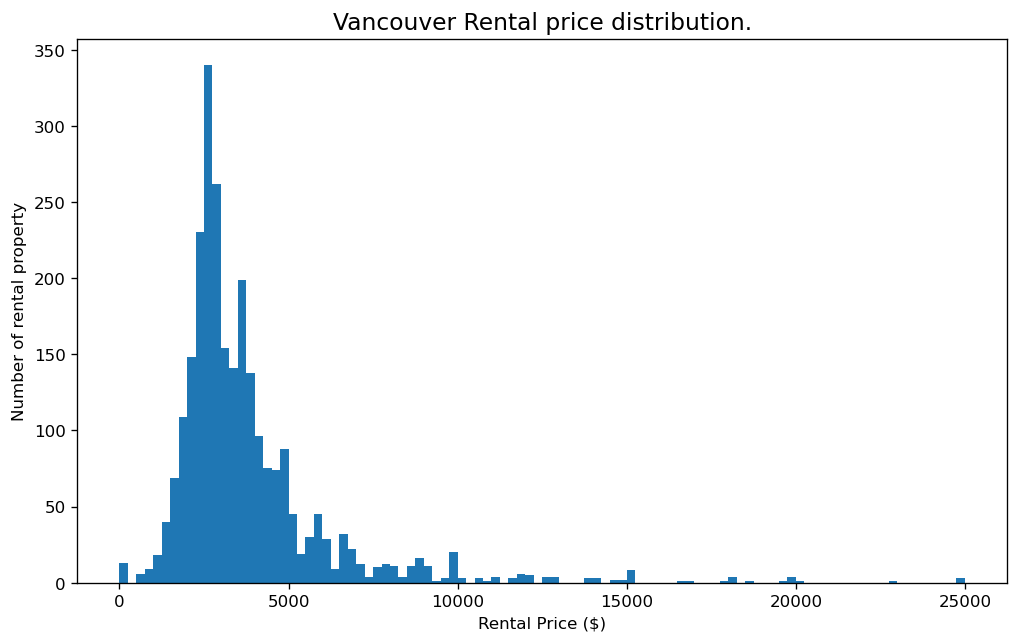

In [17]:
plt.hist(df["Price"], bins=100)
plt.title(f'{city} Rental price distribution.', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

## Relationship between Price and SQFT

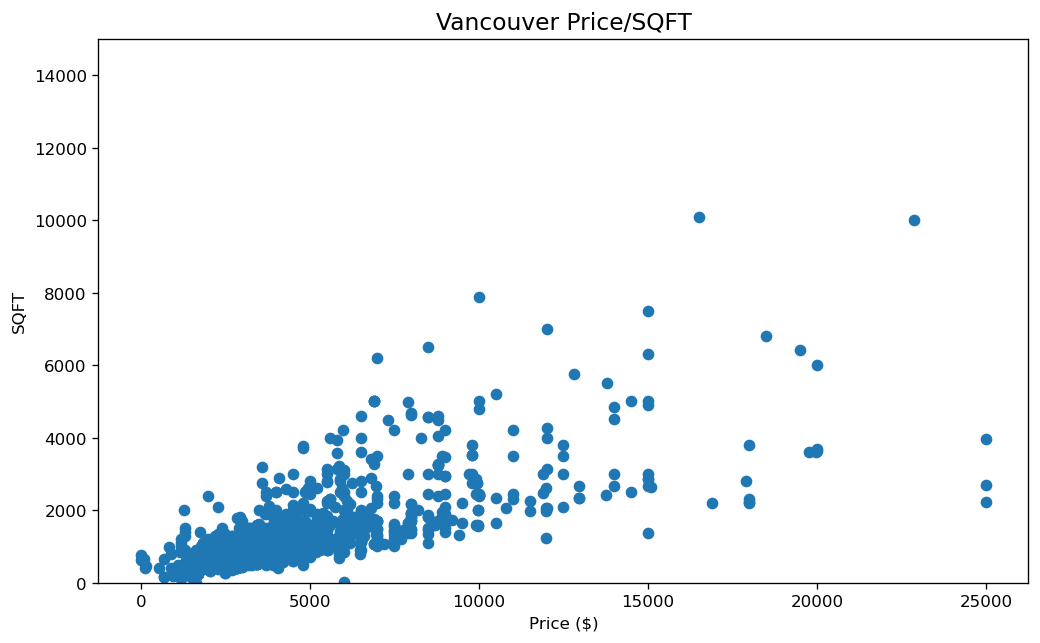

In [18]:
# Relationship between SQFT and Price
plt.scatter(x=df["Price"], y=df["SQFT"])
plt.ylim((0, 15000))
plt.title(f"{city} Price/SQFT", fontsize=14)
plt.xlabel(f"Price ($)")
plt.ylabel(f"SQFT");

Get the per SQFT price. 

In [19]:
df["Price/SQFT"] = df["Price"] / df["SQFT"]
p_per_sqft_df = df[["Neighborhood", "Bedroom", "Price", "Price/SQFT"]].sort_values(by="Price/SQFT", ascending=False)

In [20]:
# Drop rows if sqft is zero
p_per_sqft_df.fillna(0, inplace=True)
no_sqft_idx = p_per_sqft_df[p_per_sqft_df["Price/SQFT"] == 0].index
p_per_sqft_df.drop(no_sqft_idx, axis=0, inplace=True)

In [21]:
# Drop rows if Price/SQFT > $20
p_per_sqft_df = p_per_sqft_df[p_per_sqft_df["Price/SQFT"] < 20]

## Distribution of Per SQFT Price

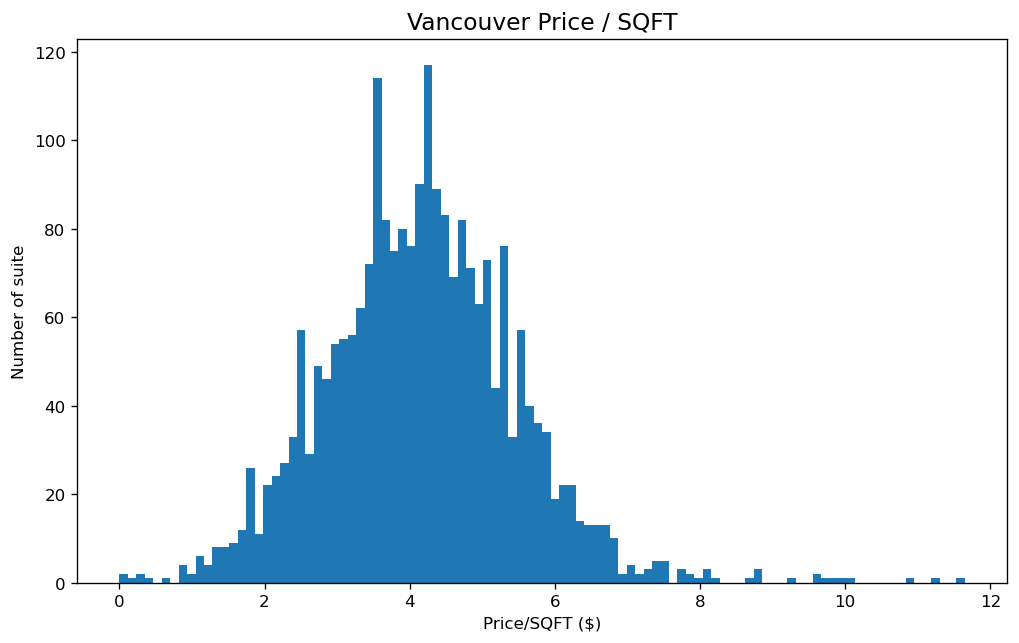

In [22]:
plt.hist(p_per_sqft_df["Price/SQFT"], bins=100)
plt.title(f"{city} Price / SQFT", fontsize=14)
plt.xlabel("Price/SQFT ($)")
plt.ylabel("Number of suite");

In [23]:
# Average, Min, Max Price/SQFT in each area
p_per_sqft_df["Neighborhood"].value_counts().head(15)

west vancouver      1210
downtown             275
yaletown             146
kitsilano             60
vancouver             58
west end              48
coal harbour          39
mount pleasant        23
burnaby               20
olympic village       18
marpole               14
ubc                   13
gastown               10
south granville       10
point grey             9
Name: Neighborhood, dtype: int64

In [24]:
# Drop all of the neighborhood is 1. 
p_per_neighbor = p_per_sqft_df.groupby(by="Neighborhood").agg({"Price/SQFT": ['count', 'mean', 'min', 'max']})
p_per_neighbor['Price/SQFT'].sort_values(by='count', ascending=False).head(15)

,count,mean,min,max
Neighborhood,,,,
west vancouver,1210,4.013749,0.001592,11.650485
downtown,275,5.001194,0.001325,10.877447
yaletown,146,4.873759,1.842308,8.097166
kitsilano,60,3.895008,1.090909,6.211111
vancouver,58,3.524439,1.076923,6.199586
west end,48,5.014853,3.406818,7.096531
coal harbour,39,4.466780,2.765152,6.925743
mount pleasant,23,4.515250,2.227273,5.808758
burnaby,20,3.475432,2.093023,4.672897


## Number of ads on each bedroom

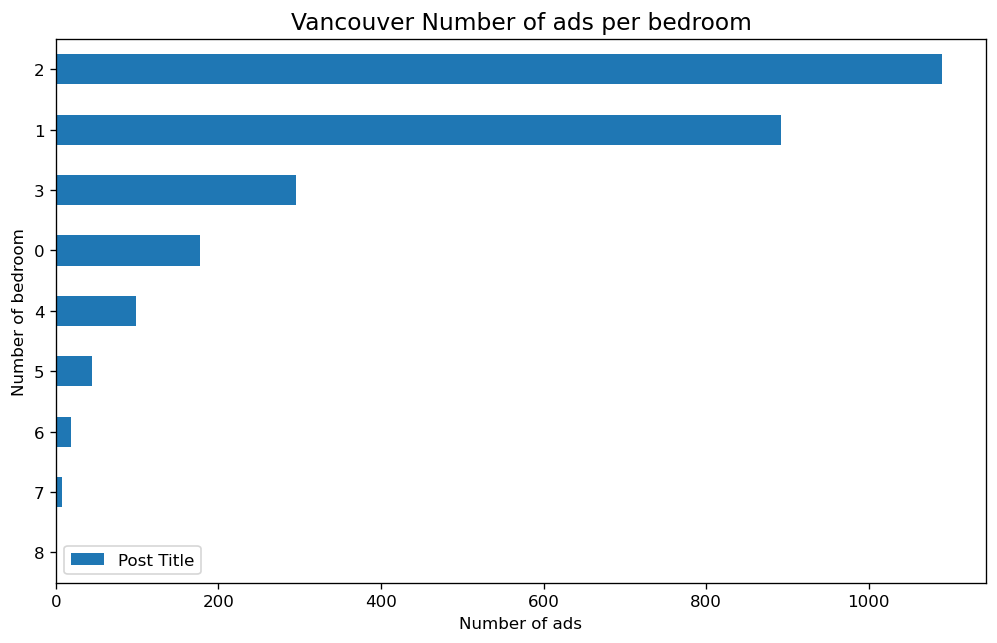

In [25]:
num_bed = df.groupby('Bedroom').agg({'Post Title': 'count'}).sort_values(by='Post Title', ascending=True)
num_bed.plot(kind='barh')
plt.title(f"{city} Number of ads per bedroom", fontsize=14)
plt.xlabel("Number of ads")
plt.ylabel("Number of bedroom");

In [26]:
# Percentage of the number of listing. 
num_bed["percent"] = num_bed / len(df) * 100
num_bed.rename(columns={'Post Title': "Number of Ads", 'percent': 'Percentage'}, inplace=True)

In [27]:
num_bed

,Number of Ads,Percentage
Bedroom,,
8,1,0.038110
7,7,0.266768
6,19,0.724085
5,44,1.676829
4,99,3.772866
0,177,6.745427
3,295,11.242378
1,892,33.993902
2,1090,41.539634


In [28]:
# Price less than $300
df[df['Price'] < 300]

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT
163,VANVAN,2022-12-21 14:39:00,2022-12-21,14:39:00,scam! beware 1 bdrm in freesia building downto...,https://vancouver.craigslist.org/van/apa/d/van...,downtown,1,755.0,1,False,0.001325
347,VANVAN,2022-12-21 08:13:00,2022-12-21,08:13:00,Westsea Place - (Westend) - Studio & 1 Bedroom...,https://vancouver.craigslist.org/van/apa/d/van...,1644 nelson st.,0,NaN,0,False,NaN
1409,VANVAN,2022-12-17 15:59:00,2022-12-17,15:59:00,Need help with housing,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,0,NaN,1,False,NaN
1485,VANVAN,2022-12-16 18:53:00,2022-12-16,18:53:00,New basement suite in Riley Park Neighbourhood,https://vancouver.craigslist.org/van/apa/d/van...,riley park,1,NaN,140,False,NaN
1936,VANVAN,2022-12-13 11:30:00,2022-12-13,11:30:00,DO NOT LIVE HERE - 124 DUNLEVY AVE,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,0,NaN,0,False,NaN
2062,VANVAN,2022-12-12 13:20:00,2022-12-12,13:20:00,Vancouver Furnished Master Bedroom for Rent,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,1,400.0,120,True,0.300000
2394,VANVAN,2022-12-08 14:02:00,2022-12-08,14:02:00,DO NOT RENT 1310 WEST 10TH AVE,https://vancouver.craigslist.org/van/apa/d/van...,fairview,1,NaN,0,False,NaN
2514,VANVAN,2022-12-06 21:27:00,2022-12-06,21:27:00,Sublet available Vancouver Dec 19th to Jan 2nd,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,1,NaN,90,False,NaN
2599,VANVAN,2022-12-06 01:57:00,2022-12-06,01:57:00,No Cooking is Illegal,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,1,NaN,0,False,NaN
2777,VANVAN,2022-12-04 15:12:00,2022-12-04,15:12:00,DT One Bedroom One Bath Furnished Dec 21-29 2022,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,1,650.0,100,True,0.153846


This post is daily rental. From this, I assume teh rental price around $100 would be daily rental suite. 

What about $1 or $0 posts?

In [29]:
# $1 ads
one_dollar = df[df["Price"] == 1]
one_dollar["Post URL"]

163     https://vancouver.craigslist.org/van/apa/d/van...
1409    https://vancouver.craigslist.org/van/apa/d/van...
3043    https://vancouver.craigslist.org/van/apa/d/van...
Name: Post URL, dtype: object

In [30]:
# $0 ads
zero_dollar = df[df["Price"] == 0]
zero_dollar

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT
347,VANVAN,2022-12-21 08:13:00,2022-12-21,08:13:00,Westsea Place - (Westend) - Studio & 1 Bedroom...,https://vancouver.craigslist.org/van/apa/d/van...,1644 nelson st.,0,NaN,0,False,NaN
1936,VANVAN,2022-12-13 11:30:00,2022-12-13,11:30:00,DO NOT LIVE HERE - 124 DUNLEVY AVE,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,0,NaN,0,False,NaN
2394,VANVAN,2022-12-08 14:02:00,2022-12-08,14:02:00,DO NOT RENT 1310 WEST 10TH AVE,https://vancouver.craigslist.org/van/apa/d/van...,fairview,1,NaN,0,False,NaN
2599,VANVAN,2022-12-06 01:57:00,2022-12-06,01:57:00,No Cooking is Illegal,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,1,NaN,0,False,NaN


I think it most likely 0 dollar and 1 dollar ads are just not showing the price, so I will drop those rows from DataFrame. 

In [31]:
# Drop low-end outliers rows
drop_index = []
for idx in one_dollar.index:
    drop_index.append(idx)
for idx in zero_dollar.index:
    drop_index.append(idx)
print(f"Original DataFrame Size:{len(df)}\nNumber of Dropped Rows: {len(drop_index)}")
df.drop(drop_index,axis=0, inplace=True)
print(f"DataFrame size after drop rows: {len(df)}")

Original DataFrame Size:2624
Number of Dropped Rows: 7
DataFrame size after drop rows: 2617


## Analyze - 1

From the Histgram, the highest amount of rental is between 1000 to 5000. First I look what kind of market above 5000. 

I call this as 

## High-End market research


In [32]:
# top 100 higest price 
top_100_price = df[['Post Datetime', 'Neighborhood', 'Bedroom', 'SQFT', 'Price', 'IsFurnished']].sort_values(
                by="Price", ascending=False).head(100)
top_100_price.head(30)


,Post Datetime,Neighborhood,Bedroom,SQFT,Price,IsFurnished
2080,2022-12-12 10:56:00,west vancouver,4,3958.0,25000,False
698,2022-12-20 11:11:00,west vancouver,2,2694.0,25000,True
746,2022-12-20 09:41:00,west vancouver,3,2223.0,24995,True
1031,2022-12-19 12:19:00,west vancouver,6,10000.0,22880,True
1958,2022-12-13 08:57:00,west vancouver,3,3636.0,20000,False
967,2022-12-19 14:21:00,dowtown,4,3700.0,19998,False
503,2022-12-20 17:44:00,west vancouver,7,6000.0,19995,True
323,2022-12-21 09:21:00,west vancouver,3,3600.0,19975,False
969,2022-12-19 14:21:00,west vancouver,3,3600.0,19750,False
36,2022-12-21 19:42:00,shaughnessy,5,6426.0,19500,False


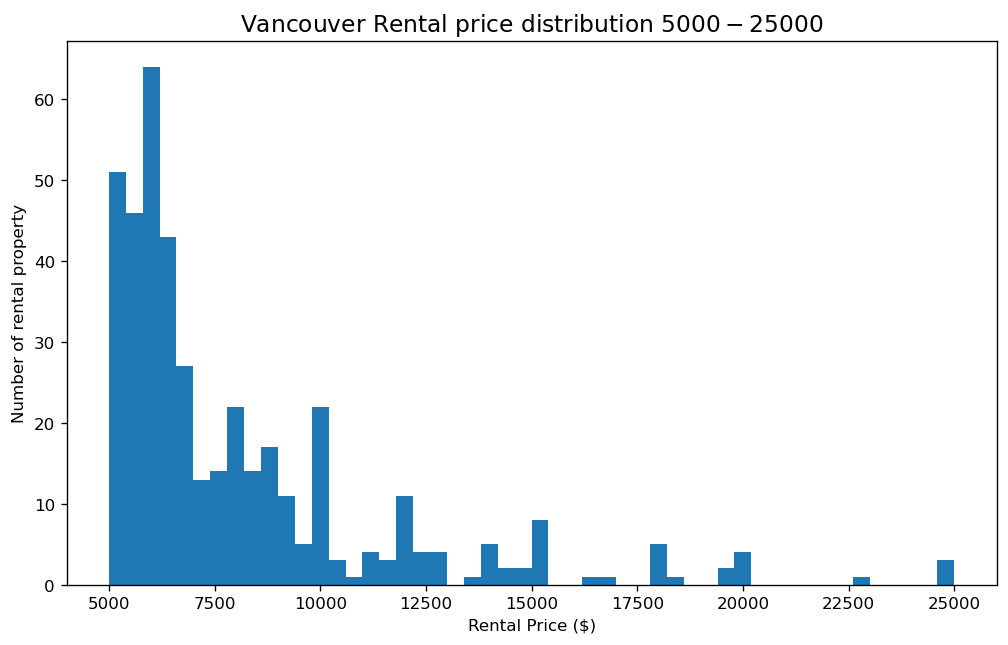

In [33]:
# What about distribution $5000 and up?
price_range = (5000, df["Price"].max())
plt.hist(df["Price"], bins=50, range=price_range)
plt.title(f'{city} Rental price distribution ${price_range[0]} - ${price_range[1]}', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

In [34]:
# Get URL on 2 Bedroom suite in top 100. 
highest_two_bed = top_100_price[top_100_price['Bedroom'] == 2]
highest_two_bed_idx = highest_two_bed.index
for idx in highest_two_bed_idx:
    print(f'Index Number - {idx} : {df.loc[idx]["Post URL"]}')


Index Number - 698 : https://vancouver.craigslist.org/van/apa/d/vancouver-furnished-two-bedroom-sub/7560020204.html
Index Number - 2451 : https://vancouver.craigslist.org/van/apa/d/vancouver-vancouver-downtown-fairmont/7554964282.html
Index Number - 2903 : https://vancouver.craigslist.org/van/apa/d/rare-harbour-green-one-ft-stunning/7563703745.html
Index Number - 3044 : https://vancouver.craigslist.org/van/apa/d/vancouver-waterfront-luxurious-bedroom/7561685356.html
Index Number - 659 : https://vancouver.craigslist.org/van/apa/d/vancouver-uniqueaccommodationscom/7567894912.html
Index Number - 118 : https://vancouver.craigslist.org/van/apa/d/vancouver-breathtaking-views-2500-sq-ft/7570816160.html
Index Number - 574 : https://vancouver.craigslist.org/van/apa/d/vancouver-super-luxury-07-fairmont-bed/7565383014.html
Index Number - 1024 : https://vancouver.craigslist.org/van/apa/d/vancouver-luxurious-private-estates-of/7568768831.html
Index Number - 1035 : https://vancouver.craigslist.org/v

#### What is 0.85% RULE?

This is the rough calculation to find out the purchase price to give 5 - 8% cash flow from your rental revenue with today's motgagerate. It's not accurate number but great place to start evaluating the home price for your investment. 

In [35]:
# Average Price on those pent house
avg_rent = np.average(highest_two_bed["Price"][1:].to_numpy())
max_rent = np.max(highest_two_bed["Price"][1:].to_numpy())
# 0.85% RULE
avg_house_p = np.round(avg_rent / (0.85/100), 2)
max_house_p = np.round(max_rent / (0.85/100), 2)
print(f"Price between ${avg_house_p*0.8} - ${max_house_p}")

Price between $1122455.24 - $2117647.06


In [36]:
# Rental price higher than $5000.
more_than_5000 = df[df["Price"] > 5000]
more_than_5000.groupby(by=["Bedroom", "IsFurnished"]).agg({'SQFT': ["min", "max"],
                                                         "Price": ['min', 'max', 'count']})

SQFT           Price             
                        min      max    min    max count
Bedroom IsFurnished                                     
0       True         1357.0   1357.0   8000   8000     1
1       False        2000.0   2000.0   6500   6500     1
        True          900.0   1855.0   5500   8500     3
2       False         675.0   2936.0   5190  18000    91
        True          800.0   2873.0   5100  25000    66
3       False          14.0   4000.0   5100  20000    79
        True         1050.0   4000.0   5200  24995    31
4       False         900.0   6300.0   5200  25000    40
        True         1600.0   6800.0   5500  18500    18
5       False        1500.0   6426.0   5200  19500    26
        True         2250.0   6500.0   6088  14995     9
6       False        2300.0  10098.0   5600  16500    11
        True         4639.0  29789.0   5600  22880     6
7       False        2900.0   4800.0   6800   9995     5
        True         6000.0   6000.0  19995  19995     1
8       False        4980.0   4980.0   7900   7900     1

In [37]:
# top 10 most expensive rental in Vancouver
top_10 = top_100_price.head(10)
top_10

,Post Datetime,Neighborhood,Bedroom,SQFT,Price,IsFurnished
2080,2022-12-12 10:56:00,west vancouver,4,3958.0,25000,False
698,2022-12-20 11:11:00,west vancouver,2,2694.0,25000,True
746,2022-12-20 09:41:00,west vancouver,3,2223.0,24995,True
1031,2022-12-19 12:19:00,west vancouver,6,10000.0,22880,True
1958,2022-12-13 08:57:00,west vancouver,3,3636.0,20000,False
967,2022-12-19 14:21:00,dowtown,4,3700.0,19998,False
503,2022-12-20 17:44:00,west vancouver,7,6000.0,19995,True
323,2022-12-21 09:21:00,west vancouver,3,3600.0,19975,False
969,2022-12-19 14:21:00,west vancouver,3,3600.0,19750,False
36,2022-12-21 19:42:00,shaughnessy,5,6426.0,19500,False


In [38]:
# Then get the URL on those top 10 most expensive rental in Vancouver. 
top_10_idx = top_10.index
for idx in top_10_idx:
    print(f'Index Number - {idx}/Number of Bedroom - {df.loc[idx]["Bedroom"]}/SQFT - {df.loc[idx]["SQFT"]}/Location - {df.loc[idx]["Neighborhood"]}\n{df.loc[idx]["Post URL"]}')

Index Number - 2080/Number of Bedroom - 4/SQFT - 3958.0/Location - west vancouver
https://vancouver.craigslist.org/van/apa/d/vancouver-ultra-customized-morden/7567534610.html
Index Number - 698/Number of Bedroom - 2/SQFT - 2694.0/Location - west vancouver
https://vancouver.craigslist.org/van/apa/d/vancouver-furnished-two-bedroom-sub/7560020204.html
Index Number - 746/Number of Bedroom - 3/SQFT - 2223.0/Location - west vancouver
https://vancouver.craigslist.org/van/apa/d/vancouver-luxury-furnished-bed-den-bath/7568077632.html
Index Number - 1031/Number of Bedroom - 6/SQFT - 10000.0/Location - west vancouver
https://vancouver.craigslist.org/van/apa/d/west-vancouver-furnished-luxury-mansion/7562366149.html
Index Number - 1958/Number of Bedroom - 3/SQFT - 3636.0/Location - west vancouver
https://vancouver.craigslist.org/van/apa/d/vancouver-coal-harbour-luxury-three/7563551392.html
Index Number - 967/Number of Bedroom - 4/SQFT - 3700.0/Location - dowtown 
https://vancouver.craigslist.org/va

From above data, Downtown Vanvouver rental market is different world. I must make decision to define what is the outlier of high-end rental. 

If the number of the high-end prices are large enough, I can make DataFrame for only high-end and search for the high-end market opportunities. 

Clearly, I should not mix with regular market and high-end market because it will provide me biased price average to determin the valuse of the house. 

I am wondering that <a href='https://www03.cmhc-schl.gc.ca/hmip-pimh/en/TableMapChart/Table?TableId=2.1.31.3&GeographyId=2410&GeographyTypeId=3&DisplayAs=Table&GeograghyName=Vancouver'>CMHC Vancouver rental market report</a> concerns about those outliers. 

## Analyze - 2 


## Analyze under 5000, and i call them for regular market. 
* What is the percentage of the Furnished rental suite? 
* Is there any price different? 
* How many bedroom suite has most on ads? And is it any different in area?
* How much is the rental price in general? 


Tne price around $100 is most likely daily rental so I will store in different variable so I might be able to do something with them. 

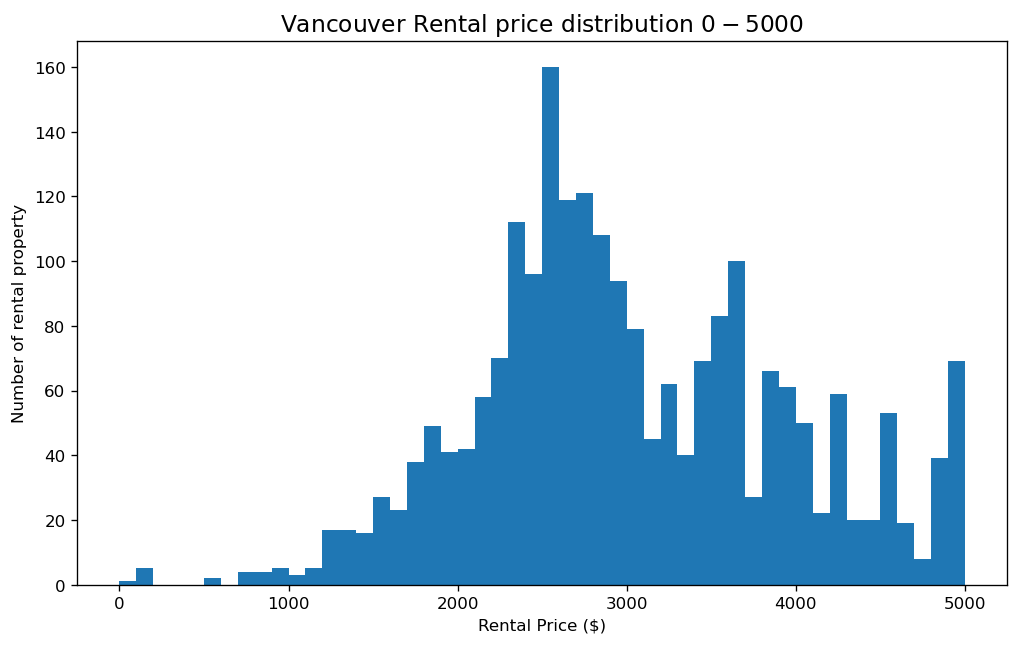

In [39]:
# What about distribution $0 - $5000?
price_range = (0, 5000)
plt.hist(df["Price"], bins=50, range=price_range)
plt.title(f'{city} Rental price distribution ${price_range[0]} - ${price_range[1]}', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

In [40]:
day_rental = df[df["Price"].between(10, 300)]
day_rental

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT
1485,VANVAN,2022-12-16 18:53:00,2022-12-16,18:53:00,New basement suite in Riley Park Neighbourhood,https://vancouver.craigslist.org/van/apa/d/van...,riley park,1,NaN,140,False,NaN
2062,VANVAN,2022-12-12 13:20:00,2022-12-12,13:20:00,Vancouver Furnished Master Bedroom for Rent,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,1,400.0,120,True,0.300000
2514,VANVAN,2022-12-06 21:27:00,2022-12-06,21:27:00,Sublet available Vancouver Dec 19th to Jan 2nd,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,1,NaN,90,False,NaN
2777,VANVAN,2022-12-04 15:12:00,2022-12-04,15:12:00,DT One Bedroom One Bath Furnished Dec 21-29 2022,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,1,650.0,100,True,0.153846
2961,VANVAN,2022-11-30 20:47:00,2022-11-30,20:47:00,1 Bedroom suite furnished,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,1,450.0,150,True,0.333333
3010,VANVAN,2022-11-29 22:17:00,2022-11-29,22:17:00,Bright Apartment to rent,https://vancouver.craigslist.org/van/apa/d/van...,kitsilano,1,NaN,100,False,NaN


In [41]:
# Drop the rental price over $5000. 
under_5000 = df.drop(more_than_5000.index, axis=0)
print(f'Drop {len(more_than_5000)} rows and data contains {len(under_5000)} rows of data.')

Drop 389 rows and data contains 2228 rows of data.


In [42]:
# then also drop daily rentals
under_5000 = under_5000.drop(day_rental.index, axis=0)
print(f'Drop {len(day_rental)} rows and data contains {len(under_5000)} rows of data.')

Drop 6 rows and data contains 2222 rows of data.


In [43]:
# What is the top 10 highest price on under $5000. Is it no outlier?
under_5000.sort_values(by="Price", ascending=False).head(10)

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT
3056,VANVAN,2022-11-28 23:02:00,2022-11-28,23:02:00,Whole House 2 levels,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,4,2033.0,5000,False,2.459420
548,VANVAN,2022-12-20 15:48:00,2022-12-20,15:48:00,2 BED + DEN W/ VIEWS FOR RENT @ CIELO!!,https://vancouver.craigslist.org/van/apa/d/van...,coal harbour,2,1277.0,5000,False,3.915427
1504,VANVAN,2022-12-16 17:36:00,2022-12-16,17:36:00,A/C Pet friendly Apartment at Cambie Gardens 7...,https://vancouver.craigslist.org/van/apa/d/van...,oakridge,2,1155.0,5000,False,4.329004
1513,VANVAN,2022-12-16 17:36:00,2022-12-16,17:36:00,A/C Furnished Short term Apartment at Avenue O...,https://vancouver.craigslist.org/van/apa/d/van...,olympic village,2,1000.0,5000,True,5.000000
3018,VANVAN,2022-11-29 18:54:00,2022-11-29,18:54:00,Rare Fully Renovated Luxury Spacious 3 Bedroom...,https://vancouver.craigslist.org/van/apa/d/van...,yaletown,3,1600.0,5000,False,3.125000
1518,VANVAN,2022-12-16 17:36:00,2022-12-16,17:36:00,A/C Furnished all inclusive Apartment SMART55 ...,https://vancouver.craigslist.org/van/apa/d/van...,downtown,2,1067.0,5000,True,4.686036
2045,VANVAN,2022-12-12 16:27:00,2022-12-12,16:27:00,UBC furnished ocean view 2 bedroom for rent,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,2,NaN,5000,True,NaN
1930,VANVAN,2022-12-13 12:18:00,2022-12-13,12:18:00,Gorgeous unfurnished 2 bed & den in Coal Harbour,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,2,1270.0,5000,False,3.937008
2768,VANVAN,2022-12-04 17:53:00,2022-12-04,17:53:00,2BD 2BATH Fully furnished | Iconic Wall Centr...,https://vancouver.craigslist.org/van/apa/d/van...,downtown,2,1067.0,5000,True,4.686036
3011,VANVAN,2022-11-29 21:45:00,2022-11-29,21:45:00,(UniqueAccommodations.com) ID:5251 Furnished 2...,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,2,1280.0,5000,True,3.906250


In [44]:
# How many rentals are $5000?
under_5000[under_5000["Price"] == 5000] 

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT
50,VANVAN,2022-12-21 18:59:00,2022-12-21,18:59:00,FRASER AND 41ST VANCOUVER EAST HOUSE 3 BED 2 BATH,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,3,2000.0,5000,False,2.500000
57,VANVAN,2022-12-21 18:39:00,2022-12-21,18:39:00,(ORCA_REF#1101-1000)2 bdrm 2 bath apt,https://vancouver.craigslist.org/van/apa/d/van...,downtown,2,1350.0,5000,False,3.703704
548,VANVAN,2022-12-20 15:48:00,2022-12-20,15:48:00,2 BED + DEN W/ VIEWS FOR RENT @ CIELO!!,https://vancouver.craigslist.org/van/apa/d/van...,coal harbour,2,1277.0,5000,False,3.915427
840,VANVAN,2022-12-19 22:20:00,2022-12-19,22:20:00,"Eco Penthouse Loft, with Private Roof Deck",https://vancouver.craigslist.org/van/apa/d/van...,west side - kitsilano,2,900.0,5000,False,5.555556
972,VANVAN,2022-12-19 14:14:00,2022-12-19,14:14:00,"--(OBsold.com)-- Stunning Furnished 1bd+den, m...",https://vancouver.craigslist.org/van/apa/d/nor...,lower lonsdale,1,733.0,5000,True,6.821282
997,VANVAN,2022-12-19 13:15:00,2022-12-19,13:15:00,5 star luxury Shangri-La hotel condo(furnished...,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,2,1045.0,5000,False,4.784689
998,VANVAN,2022-12-19 13:15:00,2022-12-19,13:15:00,$5000 / 3br - 1275ft2 - A/C 3Bed2B1Den on the ...,https://vancouver.craigslist.org/van/apa/d/van...,downtown,3,1275.0,5000,False,3.921569
1328,VANVAN,2022-12-18 16:28:00,2022-12-18,16:28:00,Luxury modern new furnished Vancouver Suite,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,2,950.0,5000,True,5.263158
1518,VANVAN,2022-12-16 17:36:00,2022-12-16,17:36:00,A/C Furnished all inclusive Apartment SMART55 ...,https://vancouver.craigslist.org/van/apa/d/van...,downtown,2,1067.0,5000,True,4.686036
1513,VANVAN,2022-12-16 17:36:00,2022-12-16,17:36:00,A/C Furnished Short term Apartment at Avenue O...,https://vancouver.craigslist.org/van/apa/d/van...,olympic village,2,1000.0,5000,True,5.000000


In [45]:
# What is the cheapest rent?
under_5000.sort_values(by="Price").head(20)

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT
2117,VANVAN,2022-12-11 21:39:00,2022-12-11,21:39:00,Double Car Garage for rent !!,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,0,400.0,550,False,1.375000
1352,VANVAN,2022-12-18 12:44:00,2022-12-18,12:44:00,Rooms in SRO building from $595,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,1,NaN,595,False,NaN
640,VANVAN,2022-12-20 12:44:00,2022-12-20,12:44:00,Nice and cozy room available (H65) (Surrey),https://vancouver.craigslist.org/van/apa/d/sur...,surrey,1,NaN,700,False,NaN
1575,VANVAN,2022-12-16 09:08:00,2022-12-16,09:08:00,Microsuite Available Now,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,1,150.0,700,False,4.666667
2847,VANVAN,2022-12-03 08:11:00,2022-12-03,08:11:00,1 bedroom available for rent in a shared suite,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,650.0,700,False,1.076923
615,VANVAN,2022-12-20 14:03:00,2022-12-20,14:03:00,Unique Basement Suite with High Ceiling,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,1,150.0,700,False,4.666667
532,VANVAN,2022-12-20 16:32:00,2022-12-20,16:32:00,1 bedroom in house,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,5,NaN,800,False,NaN
42,VANVAN,2022-12-21 19:40:00,2022-12-21,19:40:00,Room for rent $830/month! utilities & internet...,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,1,997.0,830,False,0.832497
665,VANVAN,2022-12-20 12:17:00,2022-12-20,12:17:00,1 bedr share with student near Langara College,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,1,NaN,850,False,NaN
17,VANVAN,2022-12-21 20:23:00,2022-12-21,20:23:00,Great location/ Fraser/63,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,0,NaN,850,False,NaN


In [46]:
# Count how many rentals are furnished 
num_furnished_suite = df[df['IsFurnished'] == True]["IsFurnished"].count()
num_unfurnished_suite = len(df) - num_furnished_suite
furnished_suite_percent = np.round((num_furnished_suite / len(df)) * 100, 2)
print(f"Number of furnished suite is {num_furnished_suite}, and it's {furnished_suite_percent}% of the entire list.")

Number of furnished suite is 630, and it's 24.07% of the entire list.


In [47]:
# Find out the number of ads on each bedrooms number.  
num_bed = np.sort(df["Bedroom"].unique())
suite_counts = []
for i in range(len(num_bed)):
    suite_count = len(df[df['Bedroom'] == num_bed[i]])
    suite_counts.append(suite_count)
    #print(f'Number of {num_bed[i]} Bedroom suite: {len(df[df["Bedroom"] == num_bed[i]])}')
#print(f"List of suite counts: {suite_counts}")

In [48]:
# Find out Mean, Max, Min of SQFT and Price of each bedroom and SUM of furnished suite and total suite on each bedroom. 
df_count = df.groupby(by=['Bedroom']).agg({'SQFT': ['mean', 'max', 'min'],
                                                 'Price': ['mean', 'max', 'min'],
                                                  'IsFurnished': ['sum', 'count']})
df_count['percent furnished'] = df_count['IsFurnished']['sum'] / df_count["IsFurnished"]['count']
df_count

SQFT                         Price              IsFurnished  \
                mean      max     min         mean    max   min         sum   
Bedroom                                                                       
0         440.287582   1357.0   103.0  2323.798851   8000   550          54   
1         616.184896   2400.0     1.0  2546.274775   8500    90         249   
2         990.992951   2936.0   500.0  3960.420183  25000   990         239   
3        1562.727941   4000.0    14.0  5514.955932  24995  1000          52   
4        2623.852273   6800.0   900.0  6870.989899  25000  2300          20   
5        3712.675000   6500.0  1500.0  8274.022727  19500   800           9   
6        6774.352941  29789.0  2300.0  9559.473684  22880   950           6   
7        4028.333333   6000.0  1300.0  9084.285714  19995  1300           1   
8        4980.000000   4980.0  4980.0  7900.000000   7900  7900           0   

              percent furnished  
        count                    
Bedroom                          
0         174          0.310345  
1         888          0.280405  
2        1090          0.219266  
3         295          0.176271  
4          99          0.202020  
5          44          0.204545  
6          19          0.315789  
7           7          0.142857  
8           1          0.000000

In [49]:
# Price per furnished suit on each bedroom
#df_price_furnished = df.drop(['Post Datetime', 'Post Title', 'Post URL', 'Neighborhood'], axis=1)
df_price_furnished = df.groupby(['Bedroom', 'IsFurnished']).agg({'Price': ['mean', 'max', 'min', 'count'],
                                                               "SQFT": ['mean', 'max', 'min']})
df_price_furnished

Price                              SQFT           \
                             mean    max    min count          mean      max   
Bedroom IsFurnished                                                            
0       False         2234.183333   4050    550   120    436.952381   1200.0   
        True          2522.944444   8000   1450    54    447.583333   1357.0   
1       False         2404.508607   6500     90   639    618.924354   2400.0   
        True          2910.084337   8500    100   249    609.615044   1855.0   
2       False         3740.857814  18000    990   851    973.011704   2936.0   
        True          4742.209205  25000   1175   239   1052.723214   2873.0   
3       False         5137.230453  20000   1000   243   1532.764706   4000.0   
        True          7280.096154  24995   2500    52   1692.568627   4000.0   
4       False         6324.025316  25000   2300    79   2578.130435   6300.0   
        True          9031.500000  18500   4800    20   2789.894737   6800.0   
5       False         7982.400000  19500    800    35   3722.096774   6426.0   
        True          9408.111111  14995   6088     9   3680.222222   6500.0   
6       False         8319.230769  16500    950    13   4836.333333  10098.0   
        True         12246.666667  22880   5600     6  11425.600000  29789.0   
7       False         7265.833333   9995   1300     6   3634.000000   4800.0   
        True         19995.000000  19995  19995     1   6000.000000   6000.0   
8       False         7900.000000   7900   7900     1   4980.000000   4980.0   

                             
                        min  
Bedroom IsFurnished          
0       False         103.0  
        True          180.0  
1       False           1.0  
        True          361.0  
2       False         500.0  
        True          500.0  
3       False          14.0  
        True          781.0  
4       False         900.0  
        True         1450.0  
5       False        1500.0  
        True         2250.0  
6       False        2300.0  
        True         4639.0  
7       False        1300.0  
        True         6000.0  
8       False        4980.0

Dropped extrimely low price add, and it seems no outlier on the price

In [50]:
# Count how many ads per day.1=Mon, 2=Tue, ......, 7=Sun
df["Weekday"] = df["Post Datetime"].dt.isocalendar().day
num_ad_per_day_df = df.groupby('Post Date').agg({'Post Title': 'count',
                                                "Weekday": 'first'})

num_ad_per_day_df

,Post Title,Weekday
Post Date,,
2022-11-28,1,1
2022-11-29,40,2
2022-11-30,41,3
2022-12-01,52,4
2022-12-02,44,5
2022-12-03,40,6
2022-12-04,47,7
2022-12-05,108,1
2022-12-06,73,2


Which day of the week have more ads? 

Is there any day of the week that having more ads than others? 

## Share

#### Data Visualization:
The most important thing is what information do I want to tell. 

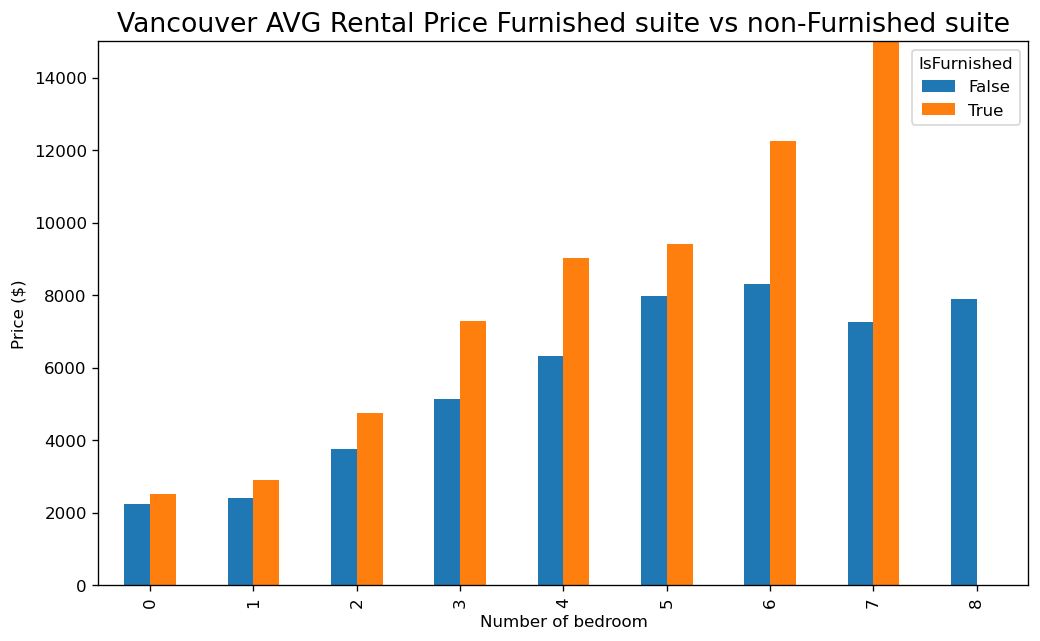

In [51]:
df_price_furnished["Price"]["mean"].unstack().plot(kind='bar')
plt.title(f'{city} AVG Rental Price Furnished suite vs non-Furnished suite', fontsize=16)
plt.xlabel('Number of bedroom')
plt.ylabel('Price ($)')
plt.ylim((0, 15000));

In [54]:
titles = []
for title in df["Post Title"][:5]:
    titles.append(title)
titles

['31ST FLOOR-Pet Welcome-Available April 1-Furnished Studio@1289 Hornby',
 '31 FLOOR-Pet Allowed Furnished Studio@1289 Hornby-Available April 1st',
 '31ST FLOOR-Pet Welcome Furnished Studio@1289 Hornby-Available April 1',
 'A/C Furnished Short Term Apartment Unit SMART 49 at The Arc Vancouver',
 '31ST FLOOR-Pet Friendly Furnished Studio@1289 Hornby-Available April 1']

In [58]:
df[['Post Datetime', 'Post Title', "Price", "Bedroom", "IsFurnished"]][:10]

,Post Datetime,Post Title,Price,Bedroom,IsFurnished
0,2022-12-21 20:52:00,31ST FLOOR-Pet Welcome-Available April 1-Furni...,2750,0,False
2,2022-12-21 20:51:00,31 FLOOR-Pet Allowed Furnished Studio@1289 Hor...,2750,0,True
3,2022-12-21 20:50:00,31ST FLOOR-Pet Welcome Furnished Studio@1289 H...,2750,0,True
4,2022-12-21 20:48:00,A/C Furnished Short Term Apartment Unit SMART ...,3000,1,True
5,2022-12-21 20:40:00,31ST FLOOR-Pet Friendly Furnished Studio@1289 ...,2750,0,True
6,2022-12-21 20:39:00,"Giant TWO BED TWO BATH w/DEN, FLEX & PARKING @...",3800,2,False
7,2022-12-21 20:38:00,35th Floor:2 BEDROOM/2 BATH+Parking+Locker→Mou...,2895,2,False
10,2022-12-21 20:37:00,Views from 29th Floor! 1-Bed+Den+Flex 1-Bath S...,2400,1,False
11,2022-12-21 20:31:00,1837 Island Ave 3 bedrooms suit top floor e,2900,3,False
12,2022-12-21 20:29:00,Pet Friendly studio with storage and patio in ...,2355,0,False


In [60]:
np.mean(df["Price/SQFT"])

5.047451078894867

## Act